## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

#Use L2 regulization
def build_reg_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

#Use drop out
def build_dout_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

#Use batch norm
def build_batchNorm_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256

In [8]:
results = {}
methods=['dout','batchNorm','reg']
for method in methods:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with %s" % (method))
    if method=='reg':
        model = build_reg_mlp(input_shape=x_train.shape[1:])
    elif method=='dout':
        model = build_dout_mlp(input_shape=x_train.shape[1:])
    elif method=='batchNorm':
        model = build_batchNorm_mlp(input_shape=x_train.shape[1:])
        
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-%s" % method
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with dout
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 12

50000/50000 [==============================] - 3s 63us/step - loss: 1.4098 - accuracy: 0.4908 - val_loss: 1.3922 - val_accuracy: 0.5075
Epoch 47/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.4047 - accuracy: 0.4971 - val_loss: 1.3970 - val_accuracy: 0.5005
Epoch 48/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.4108 - accuracy: 0.4946 - val_loss: 1.3931 - val_accuracy: 0.5013
Epoch 49/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.4040 - accuracy: 0.4958 - val_loss: 1.4074 - val_accuracy: 0.5017
Epoch 50/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.4095 - accuracy: 0.4944 - val_loss: 1.4039 - val_accuracy: 0.5021
Experiment with batchNorm
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_______________________________

50000/50000 [==============================] - 5s 91us/step - loss: 0.3182 - accuracy: 0.8870 - val_loss: 2.5311 - val_accuracy: 0.4717
Epoch 42/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.3087 - accuracy: 0.8918 - val_loss: 2.5057 - val_accuracy: 0.4819
Epoch 43/50
50000/50000 [==============================] - 5s 92us/step - loss: 0.3004 - accuracy: 0.8944 - val_loss: 2.7519 - val_accuracy: 0.4625
Epoch 44/50
50000/50000 [==============================] - 5s 90us/step - loss: 0.2927 - accuracy: 0.8966 - val_loss: 2.5909 - val_accuracy: 0.4802
Epoch 45/50
50000/50000 [==============================] - 5s 92us/step - loss: 0.2775 - accuracy: 0.9013 - val_loss: 2.5884 - val_accuracy: 0.4764
Epoch 46/50
50000/50000 [==============================] - 5s 91us/step - loss: 0.2761 - accuracy: 0.9022 - val_loss: 3.0140 - val_accuracy: 0.4428
Epoch 47/50
50000/50000 [==============================] - 5s 90us/step - loss: 0.2560 - accuracy: 0.9103 - val_loss: 2.8742

50000/50000 [==============================] - 3s 60us/step - loss: 1.0416 - accuracy: 0.6637 - val_loss: 1.4811 - val_accuracy: 0.5346
Epoch 40/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0468 - accuracy: 0.6622 - val_loss: 1.5304 - val_accuracy: 0.5165
Epoch 41/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.0343 - accuracy: 0.6654 - val_loss: 1.5675 - val_accuracy: 0.5101
Epoch 42/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0242 - accuracy: 0.6707 - val_loss: 1.5211 - val_accuracy: 0.5398
Epoch 43/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.0191 - accuracy: 0.6743 - val_loss: 1.5591 - val_accuracy: 0.5201
Epoch 44/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0047 - accuracy: 0.6795 - val_loss: 1.5382 - val_accuracy: 0.5344
Epoch 45/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0014 - accuracy: 0.6801 - val_loss: 1.5507

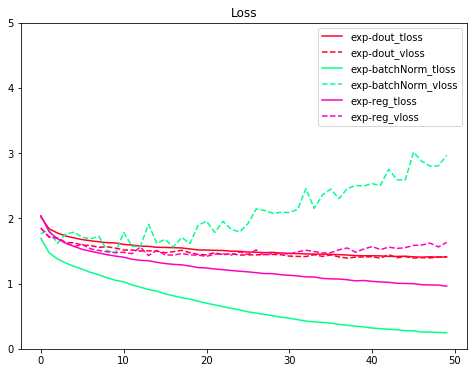

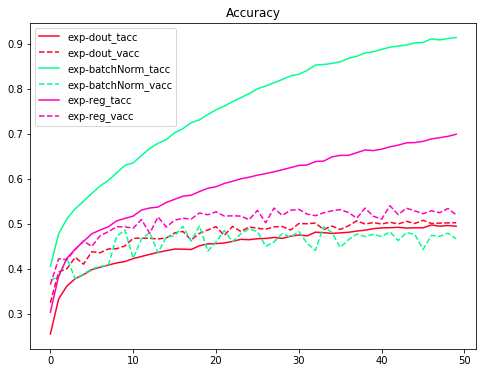

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 3

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond+'_tloss', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond+'_vloss', color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond+'_tacc', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond+'_vacc', color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [ ]:
#drop out比較不容易over fitting
#batch norm比較容易over fitting